In [1]:
import shutil
from functools import reduce

import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kaggle_pfs.data import readers
from pyspark.sql import SparkSession

sns.set_theme(style="white")

In [2]:
spark = SparkSession.builder.appName("Predict Future Sales").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/06 11:08:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sales_train = (
    spark.read.options(header=True, dateFormat="dd.MM.yyyy")
    .schema(
        "date DATE, date_block_num INT, shop_id INT, item_id INT, item_price DOUBLE, item_cnt_day DOUBLE"
    )
    .csv(readers.data_path("raw", "sales_train.csv"))
)
sales_train.createOrReplaceTempView("sales_train")

In [4]:
test_set = (
    spark.read.options(header=True)
    .schema("ID INT, shop_id INT, item_id INT")
    .csv(readers.data_path("raw", "test.csv"))
)
test_set.createOrReplaceTempView("test_set")

In [5]:
spark.sql(
    "select count(distinct shop_id, item_id), count(*) as total from sales_train"
).show()

+--------------------------------+-------+
|count(DISTINCT shop_id, item_id)|  total|
+--------------------------------+-------+
|                          424124|2935849|
+--------------------------------+-------+



In [6]:
spark.sql(
    "select count(distinct shop_id,  item_id), count(*) as total from test_set"
).show()

+--------------------------------+------+
|count(DISTINCT shop_id, item_id)| total|
+--------------------------------+------+
|                          214200|214200|
+--------------------------------+------+



Since our predictions are supposed to be in monthly frequency,
let's aggregate `item_cnt_day` grouping by $\left( date, shop\_id, item\_id \right)$.

In [7]:
yearmon_sales = spark.sql(
    """
select date_trunc('MM', `date`) as yearmon, date_block_num, shop_id, item_id, sum(item_cnt_day) as item_cnt
from sales_train
group by yearmon, date_block_num, shop_id, item_id
"""
).cache()
yearmon_sales.createOrReplaceTempView("yearmon_sales")

In [8]:
yearmon_sales.select("item_cnt").summary().show()

+-------+-----------------+
|summary|         item_cnt|
+-------+-----------------+
|  count|          1609124|
|   mean|2.267200041761853|
| stddev|8.649881798050128|
|    min|            -22.0|
|    25%|              1.0|
|    50%|              1.0|
|    75%|              2.0|
|    max|           2253.0|
+-------+-----------------+



Let's compare our monthly train data with the test set to see what we have for each `ID`.

In [9]:
summary_test = spark.sql(
    """
select t.ID, t.shop_id, t.item_id, s.n_months, s.item_cnt, s.first_sold, s.last_sold
from test_set t
left join (
    select shop_id, item_id, count(*) as n_months, sum(item_cnt) as item_cnt, min(yearmon) as first_sold, max(yearmon) as last_sold
    from yearmon_sales
    group by shop_id, item_id
) s on s.shop_id = t.shop_id and s.item_id = t.item_id
"""
).cache()
summary_test.createOrReplaceTempView("summary_test")

In [10]:
spark.sql("select * from summary_test order by item_cnt desc").show()

+------+-------+-------+--------+--------+-------------------+-------------------+
|    ID|shop_id|item_id|n_months|item_cnt|         first_sold|          last_sold|
+------+-------+-------+--------+--------+-------------------+-------------------+
| 46360|     31|  20949|      30| 19934.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 56560|     25|  20949|      29| 14343.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 41260|     28|  20949|      31| 13458.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
|102460|     42|  20949|      30| 10514.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 37296|     12|  11373|      34|  6563.0|2013-01-01 00:00:00|2015-10-01 00:00:00|
| 37341|     12|  11370|      34|  6163.0|2013-01-01 00:00:00|2015-10-01 00:00:00|
|138160|     57|  20949|      29|  6116.0|2013-05-01 00:00:00|2015-10-01 00:00:00|
|127960|     47|  20949|      26|  4530.0|2013-05-01 00:00:00|2015-10-01 00:00:00|
| 61660|     22|  20949|      31|  4382.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 71

The first 4 pairs of $\left(shop\_id, item\_id \right)$ with `item_cnt` higher than 10k units,
while the rest have 7k or less.

In [11]:
spark.sql(
    """
select if(item_cnt is null, "null", "not null") as is_null, count(*) as n
from summary_test
group by is_null
"""
).show()

+--------+------+
| is_null|     n|
+--------+------+
|not null|111404|
|    null|102796|
+--------+------+



We don't have any train data for 102.796 pairs.

In [12]:
spark.sql(
    """
select last_sold, count(*)
from  summary_test
where item_cnt is not null
group by last_sold
order by last_sold desc
"""
).show(n=12)

+-------------------+--------+
|          last_sold|count(1)|
+-------------------+--------+
|2015-10-01 00:00:00|   28680|
|2015-09-01 00:00:00|   15078|
|2015-08-01 00:00:00|   12187|
|2015-07-01 00:00:00|    8391|
|2015-06-01 00:00:00|    5629|
|2015-05-01 00:00:00|    4528|
|2015-04-01 00:00:00|    3916|
|2015-03-01 00:00:00|    4120|
|2015-02-01 00:00:00|    3295|
|2015-01-01 00:00:00|    3196|
|2014-12-01 00:00:00|    3816|
|2014-11-01 00:00:00|    1877|
+-------------------+--------+
only showing top 12 rows



Only 28.680 pairs were sold in the month before the predictions.

For each $\left(shop\_id, item\_id \right)$, how many months of observations do we have?

In [13]:
df = spark.sql(
    """
select n_months, count(*) as n_rows
from summary_test
where item_cnt is not null
group by n_months
order by n_months
"""
).toPandas()
df.head()

,n_months,n_rows
0,1,26926
1,2,17682
2,3,12602
3,4,9760
4,5,7747


In [14]:
df["p"] = df.n_rows / df.n_rows.sum()
df["cumulative_p"] = df.p.cumsum()
df.head()

,n_months,n_rows,p,cumulative_p
0,1,26926,0.241697,0.241697
1,2,17682,0.158720,0.400417
2,3,12602,0.113120,0.513536
3,4,9760,0.087609,0.601145
4,5,7747,0.069540,0.670685


In [15]:
df.cumulative_p.apply(lambda x: f"{x:.0%}")

0      24%
1      40%
2      51%
3      60%
4      67%
5      73%
6      77%
7      81%
8      84%
9      86%
10     88%
11     90%
12     91%
13     92%
14     93%
15     94%
16     95%
17     96%
18     96%
19     97%
20     97%
21     98%
22     98%
23     98%
24     99%
25     99%
26     99%
27     99%
28     99%
29    100%
30    100%
31    100%
32    100%
33    100%
Name: cumulative_p, dtype: object

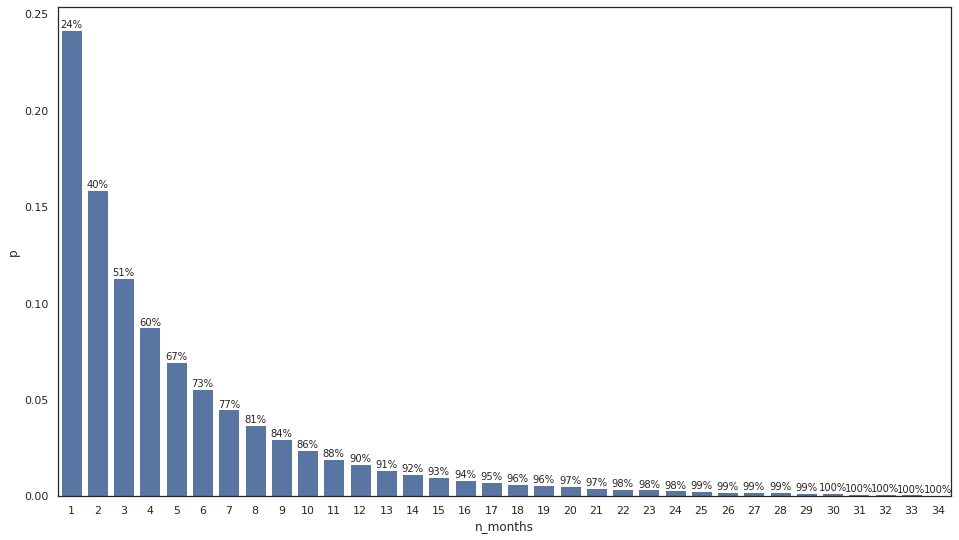

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(data=df, x="n_months", y="p", color=sns.color_palette()[0], ax=ax)
_ = ax.bar_label(ax.containers[0], labels=df.cumulative_p.apply(lambda x: f"{x:.0%}"))

90% of our valid train data have 12 observations or less.

Let's go back to our trainning data and plot the sales of all items by each shop.

In [17]:
def plot_item_cnt(df: pd.DataFrame, *, size=None, dpi=96):
    if size is None:
        size = (16, 9)
    x_px, y_px = [dpi * i for i in size]
    x_range = (df.date_block_num.min(), df.date_block_num.max())
    y_range = (df.item_cnt.min(), df.item_cnt.max())

    cvs = ds.Canvas(plot_width=x_px, plot_height=y_px, x_range=x_range, y_range=y_range)
    aggs = (
        cvs.line(df.loc[[i]], "date_block_num", "item_cnt", line_width=1)
        for i in df.index.unique()
    )
    shades = (
        tf.shade(agg, cmap=cc.glasbey[i % len(cc.glasbey)])
        for i, agg in enumerate(aggs)
    )
    img = reduce(tf.stack, shades)

    fig, ax = plt.subplots(figsize=size)  # type: plt.Figure, plt.Axes
    ax.imshow(img.to_pil(), aspect="auto", extent=(*x_range, *y_range))
    ax.grid(visible=False)

    return fig, ax

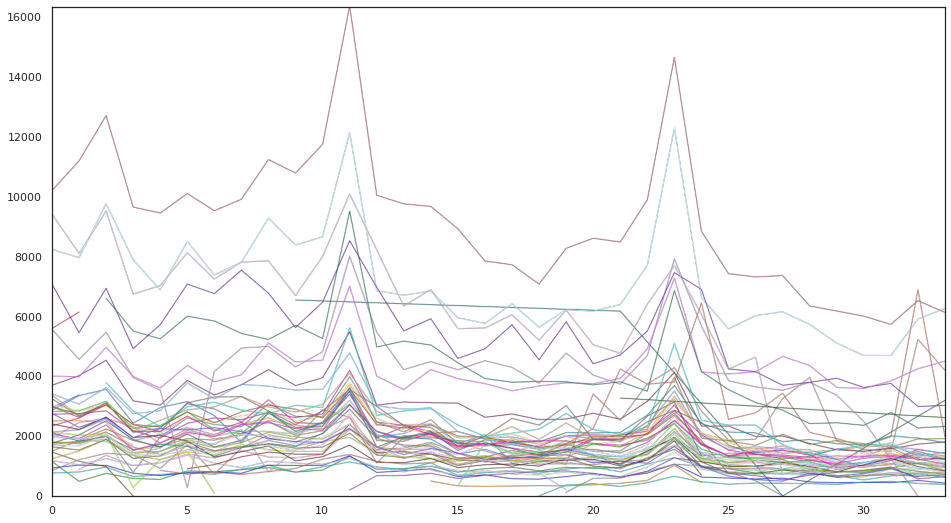

In [18]:
df = (
    spark.sql(
        f"""
    select shop_id, date_block_num, sum(item_cnt) as item_cnt
    from yearmon_sales
    group by shop_id, date_block_num
    order by shop_id, date_block_num
    """
    )
    .toPandas()
    .set_index("shop_id")
)

_ = plot_item_cnt(df)

Since we have many items, let's plot only the 256 most sold.

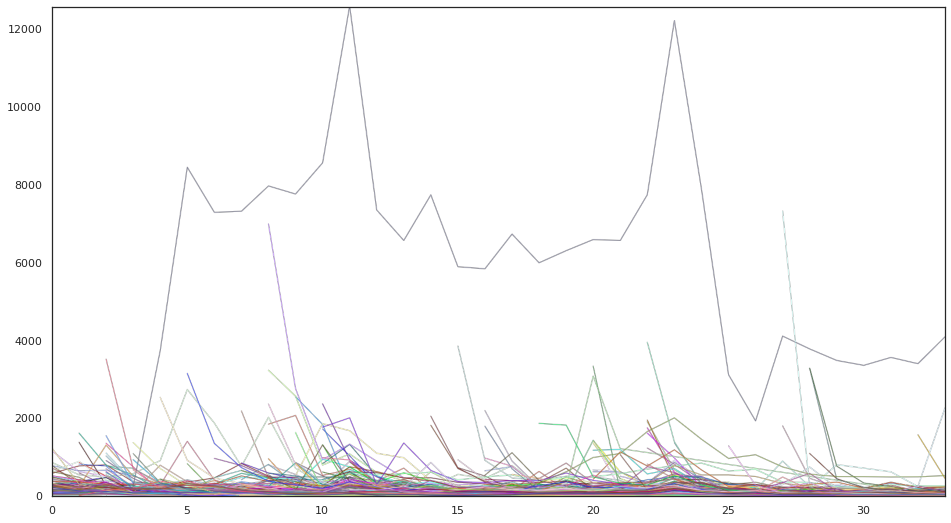

In [19]:
df = (
    spark.sql(
        f"""
    select ys.item_id, ys.date_block_num, sum(ys.item_cnt) as item_cnt
    from yearmon_sales ys
    right join (
      select item_id, sum(item_cnt) as item_cnt
      from yearmon_sales
      group by item_id
      order by item_cnt desc
      limit 256
    ) ts on ts.item_id = ys.item_id
    group by ys.item_id, ys.date_block_num
    order by ys.item_id, ys.date_block_num
    """
    )
    .toPandas()
    .set_index("item_id")
)

_ = plot_item_cnt(df)

Remove the top 10 and plot again.

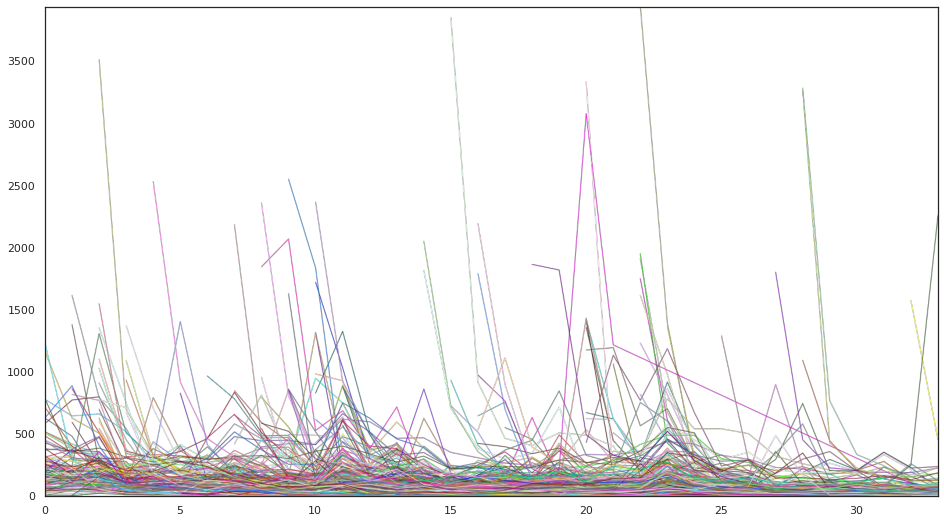

In [20]:
item_exclusion = (
    df.groupby("item_id")[["item_cnt"]]
    .sum()
    .sort_values(by="item_cnt", ascending=False)
    .head(n=10)
    .index.to_list()
)

_ = plot_item_cnt(df.loc[~df.index.isin(item_exclusion)])

Most of the sales occurs in the first month.

Write a dataset with the following shape:

| shop_id | item_id | 0   | ... | 33  |
|---------|---------|-----|-----|-----|
| 1       | 1       | 23  | ... | 3   |
| 1       | 2       | 20  | ... | 4   |


In [21]:
out_folder = readers.data_path("processed", "items_by_month.orc")
shutil.rmtree(out_folder, ignore_errors=True)

(
    yearmon_sales.groupBy(["shop_id", "item_id"])
    .pivot("date_block_num")
    .sum("item_cnt")
    .fillna(0)
    .write.orc(out_folder)
)

22/07/06 11:11:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
